<a href="https://colab.research.google.com/github/dragosconst/Anomaly-Detection/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Env preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/kaggle_ag_dataset.zip" -d "/content/data/"

Archive:  /content/drive/MyDrive/kaggle_ag_dataset.zip
  inflating: /content/data/test.csv  
  inflating: /content/data/train.csv  


# Imports and global constants

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 47.4 MB/s 
     |████████████████████████████████| 6.5 MB 27.8 MB/s 
     |████████████████████████████████| 596 kB 45.1 MB/s 
     |████████████████████████████████| 77 kB 6.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#----------- func typing -----------#
from typing import List, Tuple, Dict, Union, Iterable
#----------- base libs -------------#
import time
import csv
import random
import os
import math
#----------- progress bar ----------#
from tqdm import tqdm
#----------- pickle ----------------#
import pickle
#----------- scikit ----------------#
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
#----------- pytorch ---------------#
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
#----------- numpy -----------------#
import numpy as np
#----------- huggingface -----------#
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel, AutoConfig, AdamW, TrainingArguments, Trainer, pipeline, BertModel, BertConfig,\
                         BertForMaskedLM
#----------- plot libs -------------#
import seaborn as sn
import matplotlib.pyplot as plt

sn.set_style("darkgrid")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
train_path = '/content/data/train.csv'
test_path = '/content/data/test.csv'

Let's peek at the data:


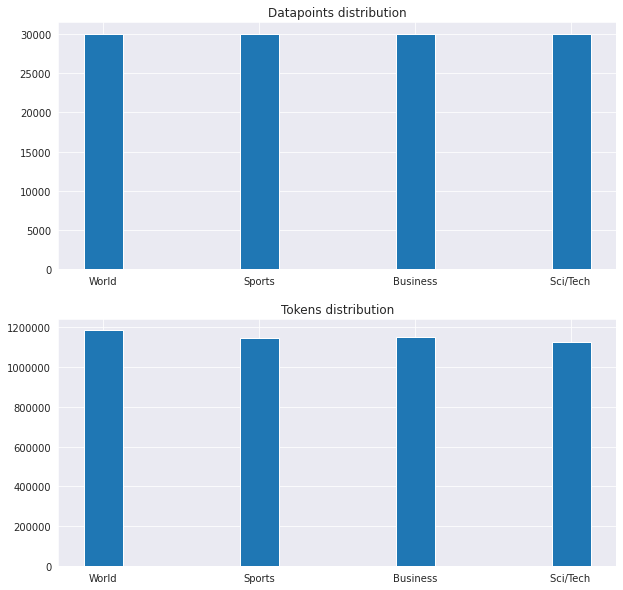

In [ ]:
class_bins = np.zeros(4)
class_tokens = np.zeros(4)
with open(train_path, "r") as f:
  reader = csv.reader(f)
  for idx, row in enumerate(reader):
    if idx == 0:
      continue
    cls, title, desc = row
    class_bins[int(cls) - 1] += 1
    title_words = len(title.split(" "))
    desc_words = len(desc.split(" ")) 
    class_tokens[int(cls) - 1] += title_words + desc_words
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
ax[0].bar(["World", "Sports", "Business", "Sci/Tech "], class_bins, width = 0.25)
ax[0].set_title("Datapoints distribution")
ax[1].bar(["World", "Sports", "Business", "Sci/Tech "], class_tokens, width = 0.25)
ax[1].ticklabel_format(style='plain', axis='y')
ax[1].set_title("Tokens distribution")
plt.show()

Huh, the dataset looks very balanced. In this case, we will arbitrarily choose one class to serve as our normal class for training, and the rest will be considered outlier classes.

In [ ]:
normal_class = 2 # we will detect Anomalies on Sports
outlier_classes = [1, 3, 4]

# I will concatenate titles and descriptions, maybe we could try differentiating them
# at training time to compare results
normal_class_instances = []
with open(train_path, "r") as f:
  reader = csv.reader(f)
  for idx, row in enumerate(reader):
    if idx == 0:
      continue
    cls, title, desc = row
    if int(cls) == normal_class:
      normal_class_instances.append(title)
      normal_class_instances.append(desc)

In [ ]:
MASK_TOK_ID = AutoTokenizer.from_pretrained("bert-base-cased").mask_token_id # apparently, [MASK] has token id 103 in regular BERT

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [ ]:
old_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
config = AutoConfig.from_pretrained('bert-base-cased')
tokenizer = old_tokenizer.train_new_from_iterator(normal_class_instances, vocab_size=20000)
tokenizer.save_pretrained("/contet/drive/MyDrive/anomaly_tok/")
# config.save_pretrained("/content/drive/MyDrive/anomaly_tok/")

('/contet/drive/MyDrive/anomaly_tok/tokenizer_config.json',
 '/contet/drive/MyDrive/anomaly_tok/special_tokens_map.json',
 '/contet/drive/MyDrive/anomaly_tok/vocab.txt',
 '/contet/drive/MyDrive/anomaly_tok/added_tokens.json',
 '/contet/drive/MyDrive/anomaly_tok/tokenizer.json')

# Datasets and Dataloaders

In [ ]:
class NormalSet(Dataset):
  def __init__(self, class_instances: List, masked_per: float=0.15):
    self.class_instances = class_instances
    self.masked_per = masked_per
    self.tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
  def __len__(self):
    return len(self.class_instances)
  def __getitem__(self, idx):
    if not isinstance(idx, Iterable):
      idx = [idx]
    data = []
    targets = []
    for i in idx:
      data_raw = self.class_instances[i]
      tokenized_bert = self.tokenizer(data_raw, add_special_tokens=True, max_length=100, padding='max_length',
                                return_tensors='pt', truncation=True)
      # ignore padding 
      at_mask = tokenized_bert["attention_mask"]
      relevant_tokens_num = len(at_mask[at_mask == 1]) - 2 # [CLS] and [SEP] shouldn't be masked, probably
      # get mask
      masked_tokens_num = math.floor(relevant_tokens_num * self.masked_per)
      masks = np.random.randint(low=1, high=relevant_tokens_num + 1, size=masked_tokens_num) # [CLS] and [SEP] should only be the first and last tokens
      data_tokens = []
      targets_tokens = []
      # mask the inputs and build the new data and targets
      for idx, tok_id in enumerate(tokenized_bert["input_ids"][0]):
        tok_id = tok_id.item() # tok_ids end up as being one-element tensors because pytorch always returns a tensor when indexing a tensor, for some reason
        gt_tok = -100 # ignore non-masked
        if idx in masks:
          gt_tok = tok_id
          tok_id = MASK_TOK_ID
        targets_tokens.append(gt_tok)
        data_tokens.append(tok_id)
      data_tokens = torch.as_tensor(data_tokens)
      targets_tokens = torch.as_tensor(targets_tokens)

      data.append(data_tokens)
      targets.append(targets_tokens)
    return torch.stack(data), torch.stack(targets)

In [ ]:
def collate_fn(data):
  tokens = []
  labels = []
  for datum in data:
    tokens.append(datum[0])
    labels.append(datum[1][0])
  return torch.stack(tokens), torch.cat(labels)

In [ ]:
dataset = NormalSet(normal_class_instances)
ds_train, ds_valid = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

BATCH_SIZE=48
dl_train = DataLoader(
    ds_train, batch_size=BATCH_SIZE, shuffle=True
)
dl_valid = DataLoader(
  ds_valid, batch_size=BATCH_SIZE, shuffle=False
)

# Create the model

In [ ]:
vocab_size = len(AutoTokenizer.from_pretrained("bert-base-cased"))

In [ ]:
class AnomalyDetectionModel(nn.Module):
  def __init__(self, num_hidden_layer: int=6, num_attention_heads: int=8, intermediate_size: int=1536, hidden_size: int=384):
    super(AnomalyDetectionModel, self).__init__()

    # Get the Transformer from the huggingface server
    config = BertConfig.from_pretrained(
        "bert-base-cased", num_hidden_layers=num_hidden_layer, num_attention_heads=num_attention_heads, intermediate_size=intermediate_size, hidden_size=hidden_size)
    self.transformer = BertForMaskedLM(config)

  def forward(self, x, labels):
    # x is B x T, where B is batch size and T is max tokens num
    # Get output from Transformer.
    out = self.transformer(x, labels=labels)
    # # out is B x T x BE, where BE is BERT encoding hidden size
    # # for each BE output that is a mask, we need to pass it through the linear layer
    # scores = []
    # for idb, batch in enumerate(x):
    #   for idt, token in enumerate(batch):
    #     if token.item() == MASK_TOK_ID:
    #       score = self.cls_scores(out[idb, idt])
    #       scores.append(score)
    return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate our model and move it to GPU
model = AnomalyDetectionModel().to(device)

# Print the model paramters
print("Model's parameters: ")
num_params = 0
for n, p in model.named_parameters():
    print('\t', n, ': ', p.size())
    num_params += p.numel()
print("Number of model parameters: ", num_params)

Model's parameters: 
	 transformer.bert.embeddings.word_embeddings.weight :  torch.Size([28996, 384])
	 transformer.bert.embeddings.position_embeddings.weight :  torch.Size([512, 384])
	 transformer.bert.embeddings.token_type_embeddings.weight :  torch.Size([2, 384])
	 transformer.bert.embeddings.LayerNorm.weight :  torch.Size([384])
	 transformer.bert.embeddings.LayerNorm.bias :  torch.Size([384])
	 transformer.bert.encoder.layer.0.attention.self.query.weight :  torch.Size([384, 384])
	 transformer.bert.encoder.layer.0.attention.self.query.bias :  torch.Size([384])
	 transformer.bert.encoder.layer.0.attention.self.key.weight :  torch.Size([384, 384])
	 transformer.bert.encoder.layer.0.attention.self.key.bias :  torch.Size([384])
	 transformer.bert.encoder.layer.0.attention.self.value.weight :  torch.Size([384, 384])
	 transformer.bert.encoder.layer.0.attention.self.value.bias :  torch.Size([384])
	 transformer.bert.encoder.layer.0.attention.output.dense.weight :  torch.Size([384, 384]

# Training the model


In [ ]:
# Defining the optimizer and loss function
optim = AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# Defining the train and evaluation functions.
def train(model, optim, dl_train):
    epoch_loss = 0
    model.train()
    preds = []
    gt = []

    times = []
    acc_loss = 0
    for idx, batch in enumerate(dl_train):
        # get rough estimate of eta
        beg = time.time()

        inputs, labels = batch
        inputs = inputs.squeeze(1) # extra dimension because of my dataset implementation Iterable quirk
        labels = labels.squeeze(1)
        # Move data to GPU
        inputs = inputs.to(device)
        # mask_labels = mask_labels.to(device)
        labels = labels.to(device).long()
        flattened_inputs = inputs.flatten()
        mask_indices = (inputs == MASK_TOK_ID).nonzero()
        acc_loss += len(flattened_inputs[flattened_inputs == MASK_TOK_ID])

        output = model(inputs.to(device), labels=labels)
        # Calculate the loss and backpropagate
        # loss = loss_fn(output, labels)
        loss = output.loss
        loss.backward()
        # Update weights
        if acc_loss >= 200:
            acc_loss = 0
            optim.step()
            optim.zero_grad()

        final = time.time()
        times.append(final - beg)

        epoch_loss += loss.item()
        
        # print a message every 100 batches
        if idx % 100 == 0:
            print(f"Loss is {loss}, time left = {(sum(times) / len(times) * (len(dl_train.dataset) - (idx + 1) * BATCH_SIZE) / BATCH_SIZE) / 60} minutes.")

    # Average the epoch losses
    epoch_loss /= len(dl_train)

    return epoch_loss


"""
broken function, doesn't do what we want it to do
"""
@torch.inference_mode()
def evaluate(model, optim, dl_valid):
    test_loss = 0
    model.eval()
    preds = []
    gt = []

    for idx, batch in enumerate(dl_valid):
        inputs, labels = batch

        inputs = inputs.squeeze(1) # extra dimension because of my dataset implementation Iterable quirk
        labels = labels.squeeze(1)

        inputs = inputs.to(device)
        labels = labels.to(device).long()

        output = model(inputs, labels=labels)

        # test_loss += loss_fn(output, labels).item()
        test_loss += output.loss.detach().item()


    test_loss /= len(dl_valid)

    return test_loss

In [ ]:
# Train loop
num_epochs = 50
best_val_loss = None

pbar = tqdm(range(num_epochs))
train_losses = []
val_losses = []


for e in tqdm(range(num_epochs)):
    train_loss = train(model, optim, dl_train)
    val_loss = evaluate(model, optim, dl_valid)

    train_losses.append(train_loss)
    val_losses.append(val_loss)


    print(f"Epoch: {e+1}, t_loss: {round(train_loss, 2)}, v_loss: {round(val_loss, 2)}")

    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './best_bert_model.pt')

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax[0].plot(range(num_epochs), train_losses, color='orange', label='train loss')
ax[0].plot(range(num_epochs), val_losses, color='blue', label='valid loss')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

Loss is 10.391664505004883, time left = 11.008643352985382 minutes.
Loss is 8.234742164611816, time left = 6.938679257438522 minutes.


  0%|          | 0/50 [01:02<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
import copy
from transformers import BertForMaskedLM, BertTokenizerFast
import torch

# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# model = AnomalyDetectionModel()
# model.load_state_dict(torch.load("trained_bert_sports_agnews.pt"))
model1 = copy.deepcopy(model)
model1.to("cpu")

model2 = BertForMaskedLM.from_pretrained('bert-base-cased')
text = "Dr. Mario Roederer and Adam Treister at Stanford University wrote FlowJo, Mac OS X analysis software for flow cytometers, high-speed, automated microscopes. Today, some 15,000 to 20,000 cytometers in use are Mac based. Aug 3"
inputs  =  tokenizer(text,  return_tensors="pt", add_special_tokens = True, truncation=True, pad_to_max_length = True,
                                         return_attention_mask = True,  max_length=100)
input_ids = inputs['input_ids']
print(tokenizer.convert_ids_to_tokens(input_ids[0]))
labels  = copy.deepcopy(input_ids) #this is the part I changed
tok_id = 14
print(tokenizer.convert_ids_to_tokens([input_ids[0][tok_id]]))
old_tok = input_ids[0][tok_id].item()
input_ids[0][tok_id] = tokenizer.mask_token_id
labels[input_ids != tokenizer.mask_token_id] = -100 

outputs = model1(input_ids, labels=labels)
# outputs =  model2(input_ids = input_ids, attention_mask = inputs['attention_mask'] , token_type_ids=inputs['token_type_ids'] , labels=labels)
loss = outputs.loss
scores = outputs.logits
print('loss',loss)
print(tokenizer.convert_ids_to_tokens([old_tok]))
pred = torch.argmax( scores[0][tok_id]).item()
logSoftmax = torch.nn.LogSoftmax(dim=1)
softmax = torch.nn.Softmax()
NLLLos = torch.nn.NLLLoss()
print("predicted token:", pred, tokenizer.convert_ids_to_tokens([pred])  )
print(NLLLos( logSoftmax(torch.unsqueeze(scores[0][tok_id], 0)), torch.tensor([pred]))) #the same as F.cross_entropy(scores.view(-1, tokenizer.vocab_size), labels.view(-1))
print(softmax(scores[0][tok_id])[pred])
print(softmax(scores[0][tok_id])[old_tok])
# print(NLLLos( logSoftmax(torch.unsqueeze(scores[0][16], 0)), torch.tensor([old_tok]))) #the same as F.cross_entropy(scores.view(-1, tokenizer.vocab_size), labels.view(-1))